Displaying samples from training data...


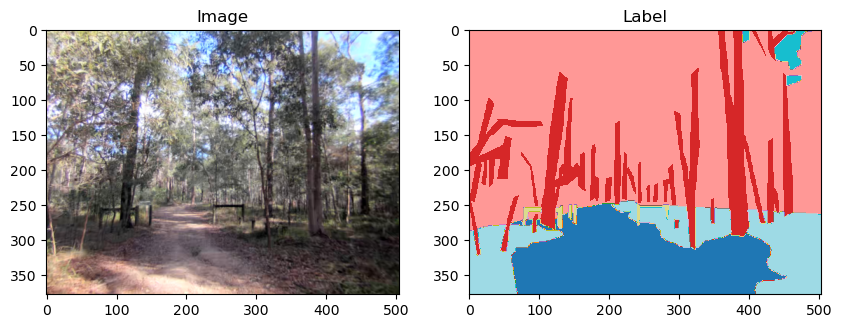

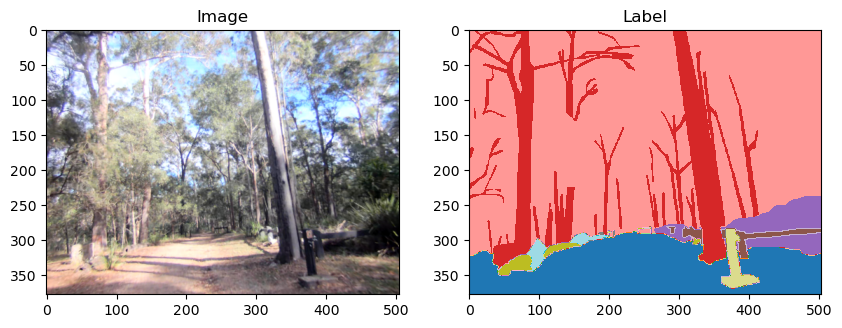

Data is prepared for PyTorch.


/opt/anaconda3/lib/python3.11/site-packages/segmentation_models_pytorch/losses/dice.py:118: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:157.)
  mask = y_true.sum(dims) > 0


Epoch 1/200, Train Loss: 3.4503, Val Loss: 3.3709, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0191
Epoch 2/200, Train Loss: 3.4338, Val Loss: 6.4184, Val Acc: 0.6058, Val mIoU: 0.0757, Val Dice: 0.0402
Epoch 3/200, Train Loss: 10.3620, Val Loss: 3.3587, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0192
Epoch 4/200, Train Loss: 3.4214, Val Loss: 3.3635, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0192
Epoch 5/200, Train Loss: 3.4265, Val Loss: 3.3623, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0192
Epoch 6/200, Train Loss: 3.4253, Val Loss: 3.3596, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0192
Epoch 7/200, Train Loss: 3.4227, Val Loss: 3.3563, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0193
Epoch 8/200, Train Loss: 3.4194, Val Loss: 3.3534, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0193
Epoch 9/200, Train Loss: 3.4167, Val Loss: 3.3504, Val Acc: 0.1630, Val mIoU: 0.0204, Val Dice: 0.0193
Epoch 10/200, Train Loss: 3.4137, Val Loss: 3.3468, Val Acc: 0.1630, Val

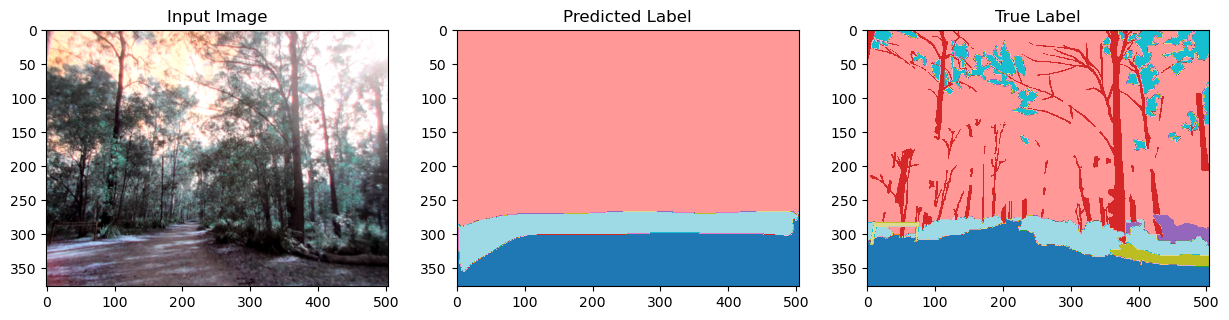

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

# Directories
image_dir = './image_small'
label_dir = './indexLabel_small'
downscale_factor = 4  # This can be adjusted

# Check if MPS is available
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Load images and labels
def load_data(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        # Load image and label
        img = cv2.imread(os.path.join(image_dir, img_file))
        lbl = cv2.imread(os.path.join(label_dir, lbl_file), cv2.IMREAD_GRAYSCALE)

        # Downscale image and label
        img = cv2.resize(img, (img.shape[1] // downscale_factor, img.shape[0] // downscale_factor), interpolation=cv2.INTER_AREA)
        lbl = cv2.resize(lbl, (lbl.shape[1] // downscale_factor, lbl.shape[0] // downscale_factor), interpolation=cv2.INTER_NEAREST)

        # Normalize image
        img = img.astype('float32') / 255.0
        
        # Append to lists
        images.append(img)
        labels.append(lbl)

    # Convert lists to arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Display some images and their corresponding labels
def display_samples(images, labels, num_samples=2):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(labels[i], cmap='tab20')
        plt.title('Label')
        
        plt.show()

# Load data
images, labels = load_data(image_dir, label_dir)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Display some samples from training data
print("Displaying samples from training data...")
display_samples(X_train, y_train)

print("Data is prepared for PyTorch.")

# Create a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the U-Net model with Dropout layers
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.5),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.5),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        bottleneck = self.bottleneck(enc)
        dec = self.decoder(bottleneck)
        return self.final(dec)

# Dice Loss
def dice_loss(preds, labels, smooth=1e-6):
    preds = torch.softmax(preds, dim=1)
    labels = labels.long()  # Ensure labels are integers
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (preds * labels_one_hot).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + labels_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

# mIoU Loss
def miou_loss(preds, labels, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    labels = labels.long()
    iou_list = []
    for cls in range(preds.shape[1]):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        iou = (intersection + smooth) / (union + smooth)
        iou_list.append(iou)
    miou = torch.mean(torch.tensor(iou_list))
    return 1 - miou

# Combined Loss (Cross Entropy + Dice Loss + mIoU Loss)
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')

    def forward(self, preds, labels):
        ce_loss = self.ce_loss(preds, labels)
        dice = self.dice_loss(preds, labels)
        miou = miou_loss(preds, labels)
        return ce_loss + dice + miou

# IoU Metric
def iou_score(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1)
    iou_list = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_list.append(float('nan'))  # If there is no ground truth, do not include in average
        else:
            iou_list.append((intersection / union).item())
    return np.nanmean(iou_list)  # Return the mean IoU, ignoring NaN values

# Accuracy Metric
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float().sum()
    total = labels.numel()
    return correct / total

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Save the U-Net model
def save_unet_model(model, path):
    torch.save(model.state_dict(), path)

# Load the weight matrix of the pre-trained U-Net model
def load_unet_weights(path):
    state_dict = torch.load(path, map_location=device)
    final_weight = state_dict['final.weight'].cpu().numpy()
    final_bias = state_dict['final.bias'].cpu().numpy()
    return final_weight, final_bias

# Convert weight matrix to SVD readable format
def prepare_svd(weight_matrix):
    original_shape = weight_matrix.shape
    
    # Reshape the weight tensor to 2D
    reshaped_weight = weight_matrix.reshape(original_shape[0], -1)
    
    # Perform SVD
    U, Sigma, Vt = np.linalg.svd(reshaped_weight, full_matrices=False)
    
    # Convert to torch tensors and make them trainable
    U = torch.tensor(U, dtype=torch.float32, requires_grad=True)
    Sigma = torch.tensor(Sigma, dtype=torch.float32, requires_grad=True)
    Vt = torch.tensor(Vt, dtype=torch.float32, requires_grad=True)
    
    return U, Sigma, Vt, original_shape

# Function to reconstruct the weight tensor from SVD components
def reconstruct_from_svd(U, Sigma, Vt, original_shape):
    # Reconstruct the weight tensor from SVD components
    Sigma_matrix = torch.diag(Sigma)
    reconstructed_weight_2d = torch.matmul(U, torch.matmul(Sigma_matrix, Vt))
    
    # Reshape the reconstructed weight tensor back to the original 4D shape
    reconstructed_weight = reconstructed_weight_2d.reshape(original_shape)
    
    return reconstructed_weight

# Input shape (height, width, channels)
input_shape = (378, 504, 3)
num_classes = 19

# Build the model
model = UNet(num_classes).to(device)

# Loss and optimizer
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create DataLoaders
batch_size = 4  # Recommended batch size 
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Split the training data into training and validation sets (80% training, 20% validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_dataset_split = CustomDataset(X_train_split, y_train_split, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)

train_loader_split = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training the main model with validation and early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200, patience=15):
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are integers
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are integers
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                val_acc += accuracy(outputs, labels).item() * inputs.size(0)
                val_iou += iou_score(outputs, labels, num_classes) * inputs.size(0)
                val_dice += (1 - dice_loss(outputs, labels).item()) * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mIoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}')
        
        early_stopping(val_loss)
        if (early_stopping.early_stop):
            print("Early stopping")
            break

# Train the main model with validation
train_model(model, train_loader_split, val_loader, criterion, optimizer)

# Save the pre-trained U-Net model
pretrained_unet_path = 'pretrained_unet.pth'
save_unet_model(model, pretrained_unet_path)

# Evaluate the pre-trained U-Net model
def evaluate_model(model, test_loader, criterion, num_classes):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_iou = 0.0
    test_dice = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are integers
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            test_acc += accuracy(outputs, labels).item() * inputs.size(0)
            test_iou += iou_score(outputs, labels, num_classes) * inputs.size(0)
            test_dice += (1 - dice_loss(outputs, labels).item()) * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    test_iou /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test mIoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}')

# Post-process the output to get class labels
def predict_and_display(model, data_loader, num_samples=1):
    model.eval()
    samples = iter(data_loader)
    with torch.no_grad():
        for i in range(num_samples):
            inputs, labels = next(samples)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(np.transpose(inputs.cpu().numpy()[0], (1, 2, 0)))
            plt.title('Input Image')
            
            plt.subplot(1, 3, 2)
            plt.imshow(torch.argmax(outputs[0], dim=0).cpu().numpy(), cmap='tab20')
            plt.title('Predicted Label')
            
            plt.subplot(1, 3, 3)
            plt.imshow(labels[0].cpu().numpy(), cmap='tab20')
            plt.title('True Label')
            
            plt.show()

# Evaluate the pre-trained U-Net model
print("Evaluating pre-trained U-Net model...")
evaluate_model(model, test_loader, criterion, num_classes)

# Display predictions for some test samples from pre-trained model
print("Displaying predictions for pre-trained U-Net model...")
predict_and_display(model, test_loader)

Epoch 1/300, Train Loss: 0.1666, Val Loss: 5.8701, Val Acc: 0.6496, Val mIoU: 0.1479, Val Dice: 0.1038
Epoch 2/300, Train Loss: 0.1679, Val Loss: 5.8974, Val Acc: 0.6522, Val mIoU: 0.1432, Val Dice: 0.0995
Epoch 3/300, Train Loss: 0.1636, Val Loss: 5.8052, Val Acc: 0.6586, Val mIoU: 0.1412, Val Dice: 0.0965
Epoch 4/300, Train Loss: 0.1642, Val Loss: 5.7500, Val Acc: 0.6565, Val mIoU: 0.1432, Val Dice: 0.0975
Epoch 5/300, Train Loss: 0.1612, Val Loss: 5.7237, Val Acc: 0.6601, Val mIoU: 0.1452, Val Dice: 0.0984
Epoch 6/300, Train Loss: 0.1665, Val Loss: 5.7290, Val Acc: 0.6675, Val mIoU: 0.1460, Val Dice: 0.0988
Epoch 7/300, Train Loss: 0.1700, Val Loss: 5.5450, Val Acc: 0.6671, Val mIoU: 0.1458, Val Dice: 0.0990
Epoch 8/300, Train Loss: 0.1619, Val Loss: 5.4157, Val Acc: 0.6678, Val mIoU: 0.1458, Val Dice: 0.0991
Epoch 9/300, Train Loss: 0.1636, Val Loss: 5.2321, Val Acc: 0.6680, Val mIoU: 0.1461, Val Dice: 0.0993
Epoch 10/300, Train Loss: 0.1650, Val Loss: 5.1888, Val Acc: 0.6709, Val 

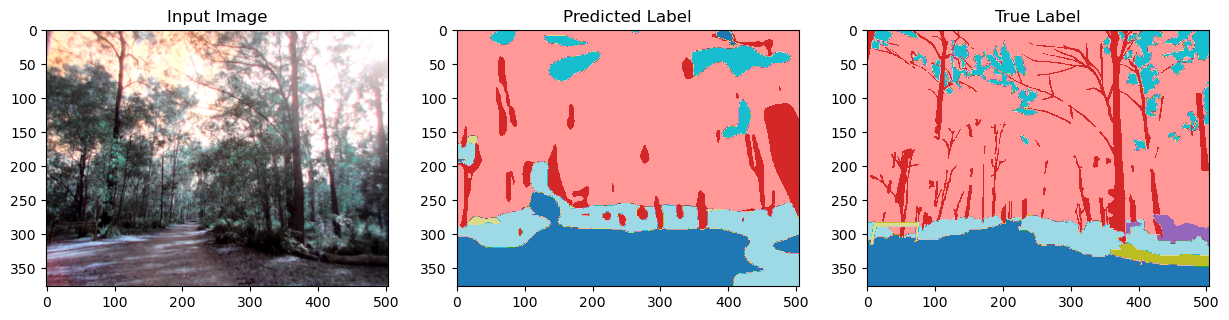

In [59]:
# SVD Integration
# Load the pre-trained U-Net model weights
final_weight, final_bias = load_unet_weights(pretrained_unet_path)

# Perform SVD on the final layer's weights
U, Sigma, Vt, original_shape = prepare_svd(final_weight)

# Reconstruct the final weight matrix from SVD components
reconstructed_final_weight = reconstruct_from_svd(U, Sigma, Vt, original_shape)

# Define a new model that reconstructs the final layer's weight from U, Sigma, and Vt
class SVDModel(nn.Module):
    def __init__(self, U, Sigma, Vt, final_bias):
        super(SVDModel, self).__init__()
        self.A = nn.Parameter(torch.eye(U.shape[0], dtype=torch.float32, requires_grad=True))
        self.U = nn.Parameter(U)
        self.Sigma = nn.Parameter(Sigma)
        self.Vt = nn.Parameter(Vt)
        self.final_bias = nn.Parameter(torch.tensor(final_bias, dtype=torch.float32, requires_grad=True))

    def forward(self):
        transformed_U = torch.matmul(self.A, self.U)
        Sigma_matrix = torch.diag(self.Sigma)
        W_reconstructed_2d = torch.matmul(transformed_U, torch.matmul(Sigma_matrix, self.Vt))
        W_reconstructed = W_reconstructed_2d.reshape(*original_shape)
        return W_reconstructed, self.final_bias

# Instantiate the SVD model
svd_model = SVDModel(U, Sigma, Vt, final_bias).to(device)

# Define optimizer for SVD model
svd_optimizer = optim.Adam(svd_model.parameters(), lr=2, weight_decay=1e-5)

# Training loop for SVD model
def train_svd_model(svd_model, model, train_loader, val_loader, criterion, svd_optimizer, num_epochs=300, patience=100):
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        svd_model.train()
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            # Reconstruct final layer's weights from SVD components
            W_reconstructed, final_bias = svd_model()
            
            # Update model final layer's weights and bias
            model.final.weight.data = W_reconstructed
            model.final.bias.data = final_bias
            
            optimizer.zero_grad()
            svd_optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            svd_optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are integers
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                val_acc += accuracy(outputs, labels).item() * inputs.size(0)
                val_iou += iou_score(outputs, labels, num_classes) * inputs.size(0)
                val_dice += (1 - dice_loss(outputs, labels).item()) * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mIoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Train the SVD model
train_svd_model(svd_model, model, train_loader_split, val_loader, criterion, svd_optimizer)

# Save the trained U-Net model after SVD optimization
save_unet_model(model, 'path_to_save_trained_unet_after_svd.pth')

# Reload the SVD-optimized model for evaluation
model_after_svd = UNet(num_classes).to(device)
model_after_svd.load_state_dict(torch.load('path_to_save_trained_unet_after_svd.pth', map_location=device))

# Evaluate the U-Net model after SVD optimization
print("Evaluating U-Net model after SVD optimization...")
evaluate_model(model_after_svd, test_loader, criterion, num_classes)

# Display predictions for some test samples from SVD-optimized model
print("Displaying predictions for U-Net model after SVD optimization...")
predict_and_display(model_after_svd, test_loader)

Evaluating U-Net model after SVD optimization...
Test Loss: 5.2992, Test Acc: 0.6381, Test mIoU: 0.2335, Test Dice: 0.1347
Displaying predictions for U-Net model after SVD optimization...


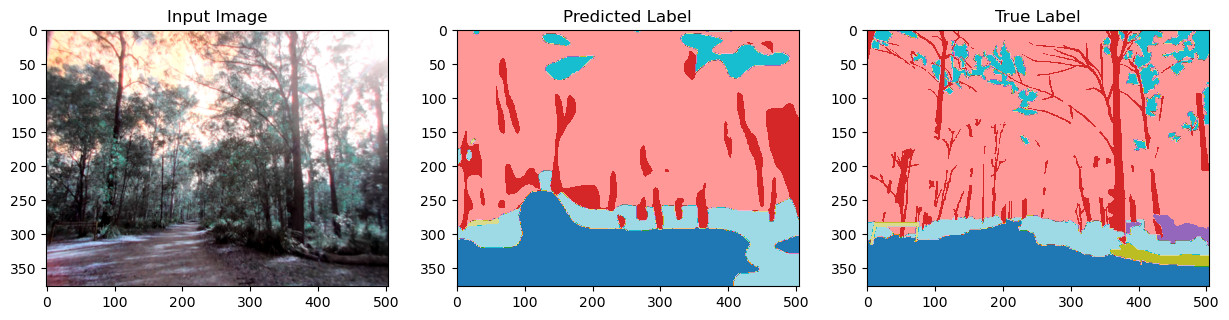

In [49]:
print("Evaluating U-Net model after SVD optimization...")
evaluate_model(model, test_loader, criterion, num_classes)

# Display predictions for some test samples from SVD-optimized model
print("Displaying predictions for U-Net model after SVD optimization...")
predict_and_display(model, test_loader)